**This notebook presents the first attempt of one-hot encoding for amino-acid sequence, and a CNN (with 20 channels) + MLP, where the parameters were chosen by us**

In [81]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import Dataset
import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam

from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import KFold

import os
from collections import Counter

from helpers import *

1. Load the dataset 

In [82]:
#load training data  
path = os.getcwd()
for i in range(3) :

    path = os.path.dirname(path)

path += '/data/'
train_df = pd.read_csv(path + 'train_v1.csv',index_col="seq_id")
train_df = train_df.drop(columns=['data_source'])
train_df = train_df.dropna()
train_df.head()

,protein_sequence,pH,tm
seq_id,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5


2. Create one-hot encoding for each sequence

In [83]:
#add a new column that contains the length of each protein sequence (before padding)
train_df['length'] = train_df['protein_sequence'].str.len()

In [84]:
test_df = pd.read_csv(path+ 'test.csv',index_col='seq_id')
test_df = test_df.drop(columns=['data_source'])
test_df['length'] = test_df['protein_sequence'].str.len()

In [85]:
# fix max_length to be 500
max_length = 500

#drop rows that exceeds this value
train_df = train_df[train_df['length'] < max_length]



In [86]:
#Encoding of the sequence, and create a new feature in the data. 
#Since encode_seq is used in most of the notebook, you can find its implementation in helpers.py

train_df['encoded_sequence'] = train_df['protein_sequence'].apply(lambda x: encode_seq(x, max_length))
test_df['encoded_sequence'] = test_df['protein_sequence'].apply(lambda x: encode_seq(x, max_length))

In [87]:
train_df['encoded_sequence'].shape

(20510,)

In [88]:
#final dataframe 
train_df.head()

,protein_sequence,pH,tm,length,encoded_sequence
seq_id,,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,"[[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0,..."
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,"[[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,"[[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,"[[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
5,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,48.4,380,"[[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [89]:
df = train_df.copy()

3. Convolutional NN with 20 channels + MLP

In [90]:
# hyperparameters
batch_size = 64
learning_rate = 0.001 # Suggested for Adam
num_epochs = 100

In [91]:
class EnzymesDataset(Dataset):
 
    def __init__(self,df,train=True):
    
        # the Amino acid sequences as an int array
        sequence= df['encoded_sequence']
        # numerical : pH and length
        numerical = df[['pH','length']].values

        # y : the target (tm)
        if train == True : 
            y=df['tm'].values
        else : 
            y = np.zeros(len(sequence))
        self.y=torch.tensor(y,dtype=torch.float32)
        #creta tensors from the numpy arrays
        self.x_sequence=torch.tensor(sequence)
       
        self.num=torch.tensor(numerical,dtype=torch.float32)
   
 
    def __len__(self):
        return len(self.y)
   
    def __getitem__(self,idx):
        return self.x_sequence[idx],self.y[idx] , self.num[idx]



In [92]:
class Conv1D_20Channels(nn.Module):

    def __init__(self):
        super().__init__()
       
        self.prot_seq_one_pooling = nn.Sequential(

            #With pooling only at the end (seen in paper)

            nn.Conv1d(20, 20,kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            
            nn.Conv1d(20, 32,kernel_size=5, stride=1, padding=2), 
            nn.ReLU(), 
         
             nn.MaxPool1d(kernel_size=3, stride=2),
            
            nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2), 
            nn.ReLU(), 
            
             nn.MaxPool1d(kernel_size=3, stride=2),  
            
            nn.Conv1d(64, 128, kernel_size=11, stride=1, padding=5), 
            nn.ReLU(), 
            
            
            nn.MaxPool1d(kernel_size=3, stride=2),
            
            nn.Conv1d(128, 1, kernel_size=5, stride=1, padding=2), 
            nn.ReLU(), 
        )
        self.numerical = nn.Sequential(
            nn.Linear(2, 2),  
        )
        self.mlp = nn.Sequential(
            nn.Linear(63, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),

            
        )

    def forward(self, x,y):
        """x: tensor of input channels
           y: tensor of (length, pH)
         """

        x = self.prot_seq_one_pooling(x.float())
       
        y = self.numerical(y)
       
        x = torch.cat((x.squeeze(1), y), 1)
      
        x = self.mlp(x)
        return x




#CROSS VALIDATION 

k_folds = 5
learning_rate = 1e-4
kfold = KFold(n_splits=k_folds, shuffle=True)
dataset = EnzymesDataset(df.reset_index(drop=True))
train_loss_history = []
test_loss_history = []
train_rho_history = []
test_rho_history = []
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    train_dl = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=32, sampler=train_subsampler)
    val_dl = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=32, sampler=test_subsampler)

    model = Conv1D_20Channels()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # defining the loss function
    criterion = nn.MSELoss()
    # checking if GPU is available
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
    
    for epoch in range(1, num_epochs + 1):
        train_loss , rho_train = train_epoch( model, optimizer, criterion, train_dl, epoch)
       

    
    test_loss , rho_test = test_epoch(model, criterion, val_dl)
        
    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)
    test_loss_history.append(test_loss)
    test_rho_history.append(rho_test)

    print(f'for fold {fold} : \n train_loss :  {train_loss}     test_loss : {test_loss} \n \n')
    
 


**4. Train model and plot**

In [93]:
train_df , val_df = split_train_test(df,frac=0.8)

train_df has shape : (16408, 5) 
 test_df has shape :  (4102, 5)


In [94]:
# create pytorch datasets
train_d = EnzymesDataset(train_df)
val_d = EnzymesDataset(val_df)


# create pytorch dataloaders
train_dl = torch.utils.data.DataLoader(train_d, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_d, batch_size=batch_size, shuffle=True)

In [95]:
#Define model, optimizer and loss
model = Conv1D_20Channels()
optimizer = Adam(model.parameters(), lr=learning_rate)
# defining the loss function
criterion = nn.MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()


In [96]:
# train and test the model (save it after each epoch)
train_loss_history = []
test_loss_history = []
train_rho_history = []
test_rho_history = []
for epoch in range(1, num_epochs + 1):
    train_loss , rho_train = train_epoch(
        model, optimizer, criterion, train_dl, epoch
    )
    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)

    
    
    test_loss , rho_test = test_epoch(model, criterion, val_dl)
    test_loss_history.append(test_loss)
    test_rho_history.append(rho_test)
    
    
#torch.save(model.state_dict(), f"2-Conv1d_OneHot_model.pth")


Test set: Average loss: 6.28e+02 
Test set: Average loss: 6.08e+02 
Test set: Average loss: 5.21e+02 
Test set: Average loss: 1.73e+02 
Test set: Average loss: 1.90e+02 
Test set: Average loss: 1.68e+02 
Test set: Average loss: 1.69e+02 
Test set: Average loss: 1.67e+02 
Test set: Average loss: 1.67e+02 
Test set: Average loss: 1.74e+02 
Test set: Average loss: 1.91e+02 
Test set: Average loss: 1.73e+02 
Test set: Average loss: 1.68e+02 
Test set: Average loss: 1.67e+02 
Test set: Average loss: 1.73e+02 
Test set: Average loss: 1.66e+02 
Test set: Average loss: 1.67e+02 
Test set: Average loss: 1.67e+02 
Test set: Average loss: 1.65e+02 
Test set: Average loss: 1.69e+02 
Test set: Average loss: 1.67e+02 
Test set: Average loss: 1.89e+02 
Test set: Average loss: 1.63e+02 
Test set: Average loss: 1.65e+02 
Test set: Average loss: 1.87e+02 
Test set: Average loss: 1.76e+02 
Test set: Average loss: 1.68e+02 
Test set: Average loss: 1.65e+02 
Test set: Average loss: 1.68e+02 
Test set: Aver

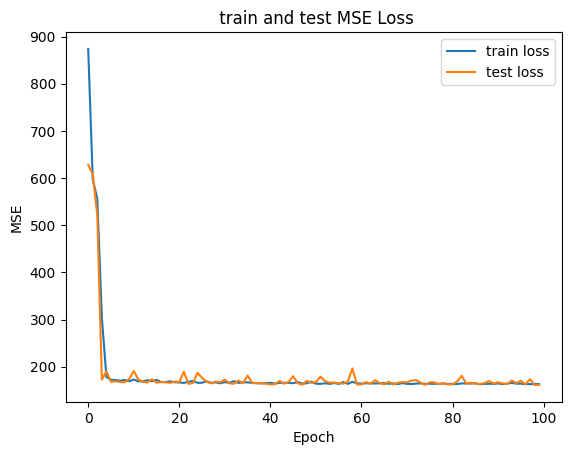

In [97]:
#create loss plot
plt.plot(train_loss_history, label='train loss')
plt.plot(test_loss_history, label='test loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title(' train and test MSE Loss')
plt.legend()
plt.savefig('Rendu2-conv1d_OneHot_Loss.png')


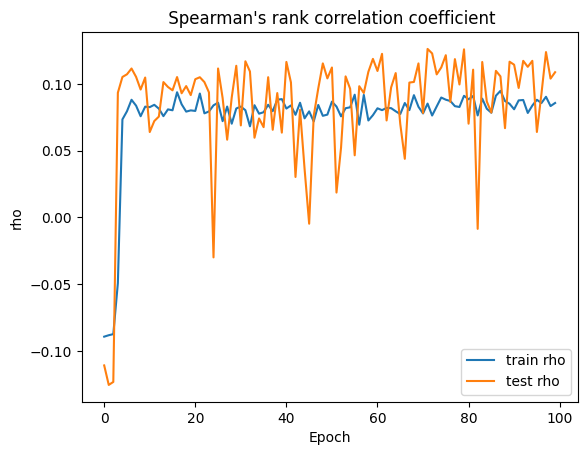

In [98]:
#create spearman coefficient plot

plt.plot(train_rho_history, label='train rho')
plt.plot(test_rho_history, label='test rho')
plt.xlabel('Epoch')
plt.ylabel('rho')
plt.title(' Spearman\'s rank correlation coefficient')
plt.legend()
plt.savefig('Rendu2-conv1d_OneHot_rho.png')

5. Prediction for Kaggle's submission

In [99]:
#Create the dataset
test_d = EnzymesDataset(test_df, False)

# create pytorch dataloaders

sub_dl = torch.utils.data.DataLoader(test_d, batch_size=batch_size, shuffle=True)
submission_df =  predict(model,sub_dl)



ValueError: could not determine the shape of object type 'Series'

In [ ]:
submission = pd.read_csv(path+ 'test.csv',index_col='seq_id')
submission['tm']=submission_df
submission = submission.drop(columns=['protein_sequence','pH','data_source'])
#test_sub.to_csv('5-AlexNet.csv', index=True)